In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import scipy

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

In [2]:
raw = pd.read_excel('QuantgeneTest.xlsx', index_col=0, header=None).T

In [3]:
df = raw.reset_index().drop(columns='index').rename(index=str, columns={'Locations':'Patient'})
df['Disease'] = 'N' #N for negative to disease A and B
df['Disease'][34:46] = 'A'
df['Disease'][55:63] = 'B'
df

,Patient,Location 0,Location 1,Location 2,Location 3,Location 4,Location 5,Location 6,Location 7,Location 8,...,Location 44,Location 45,Location 46,Location 47,Location 48,Location 49,Location 50,Location 51,Location 52,Disease
0,Patient 0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,0,0,0,N
1,Patient 1,0,0,0,0,1,1,0,1,0,...,2,0,2,0,2,1,0,0,0,N
2,Patient 2,0,1,1,0,0,0,1,0,0,...,0,0,2,1,0,0,0,1,0,N
3,Patient 3,0,0,0,0,0,0,0,0,0,...,0,0,2,1,2,2,0,0,0,N
4,Patient 4,0,0,0,0,0,0,0,0,0,...,2,0,2,1,0,1,1,1,1,N
5,Patient 5,0,0,0,0,0,3,1,0,0,...,2,5,2,0,6,4,0,1,0,N
6,Patient 6,0,0,1,0,0,0,1,0,1,...,0,3,0,0,0,1,0,0,0,N
7,Patient 7,0,1,0,0,0,0,2,0,0,...,2,0,0,0,1,1,0,1,1,N
8,Patient 8,0,0,0,0,0,3,0,0,0,...,0,0,1,1,2,1,0,0,0,N
9,Patient 9,0,1,0,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,0,N


In [4]:
#Change data type from str to numeric
numericcolumns = list(df.columns)
numericcolumns.remove('Patient')
numericcolumns.remove('Disease')
df[numericcolumns] = df[numericcolumns].apply(pd.to_numeric)

In [5]:
#Average signals for each group
Meansignals = df.groupby('Disease', as_index=False).agg(np.mean)

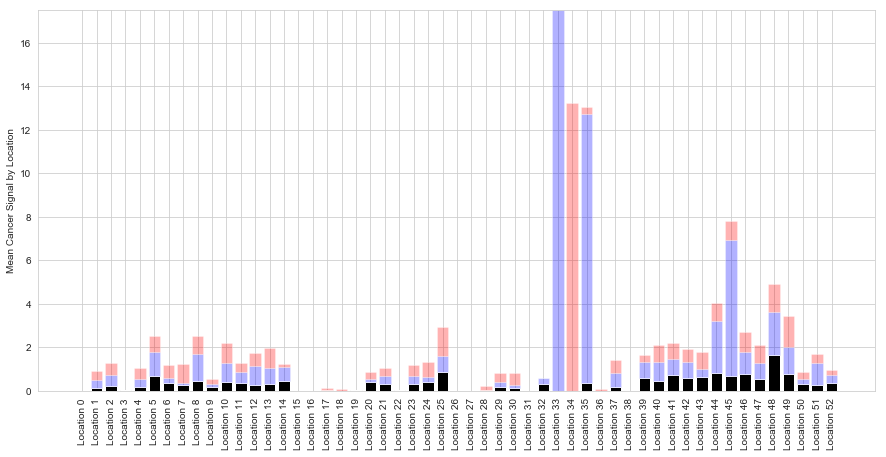

In [6]:
#Plot of the mean signal of each location for Disease A, B and No disease.
Alabels = list(Meansignals[Meansignals.Disease=='A'].columns[1:])
Avalues = Meansignals[Meansignals.Disease=='A'].iloc[0,1:]
Blabels = list(Meansignals[Meansignals.Disease=='B'].columns[1:])
Bvalues = Meansignals[Meansignals.Disease=='B'].iloc[0,1:]
Nlabels = list(Meansignals[Meansignals.Disease=='N'].columns[1:])
Nvalues = Meansignals[Meansignals.Disease=='N'].iloc[0,1:]

plt.figure(figsize=(15,7))
plt.bar(x=Nlabels, height=Nvalues, color='k')
plt.bar(x=Blabels, height=Bvalues, bottom=Nvalues, color='b', alpha=.3)
plt.bar(x=Alabels, height=Avalues, bottom=Bvalues+Nvalues, color='r', alpha=.3)
plt.xticks(rotation=90)
plt.ylabel('Mean Cancer Signal by Location')
plt.show()

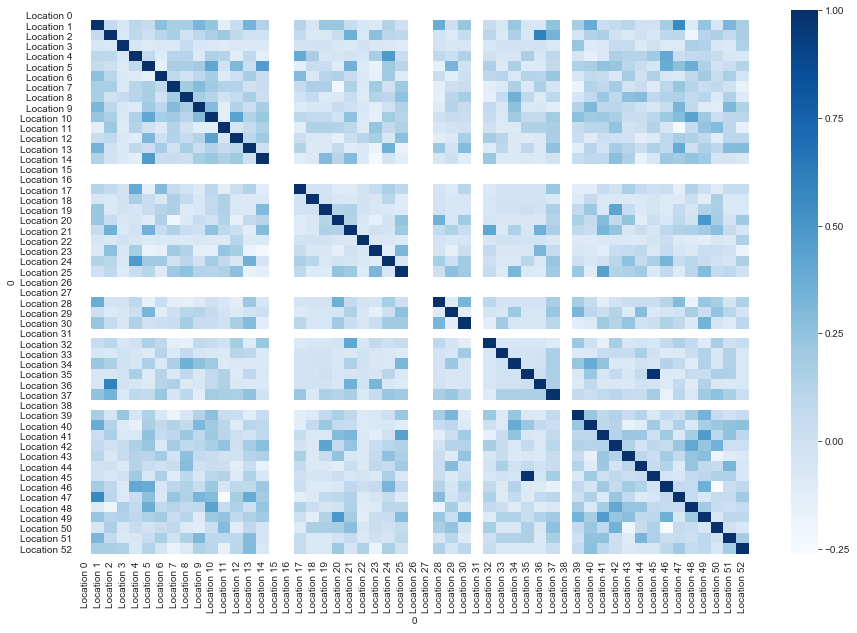

In [7]:
plt.figure(figsize=(15,10))
sns.heatmap(df[numericcolumns].corr(), cmap='Blues')
plt.show()

In [10]:
#Remove locations that have 0 cancer signals for all patients.
SignallessLocations = ['Location 0', 'Location 15', 'Location 16', 
                     'Location 26', 'Location 27', 'Location 31', 'Location 38']
for column in numericcolumns:
    if column in SignallessLocations:
        numericcolumns.remove(column)

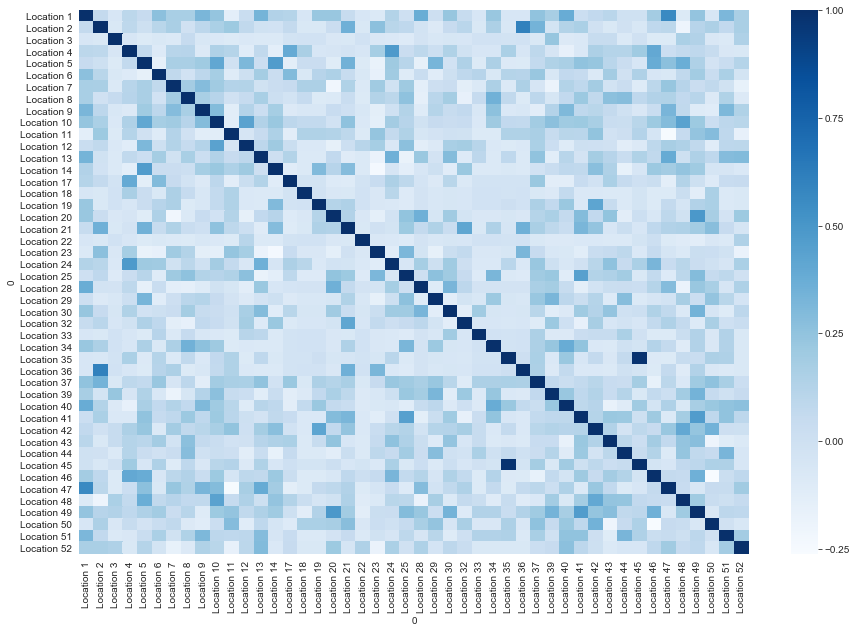

In [11]:
#Correlation table of each location.
plt.figure(figsize=(15,10))
sns.heatmap(df[numericcolumns].corr(), cmap='Blues')
plt.show()

In [12]:
def PosNeg(x):
    if x=='N':
        return 'N'
    else:
        return 'P'
df['hasDisease'] = df['Disease'].apply(lambda x: PosNeg(x))

In [248]:
scaler = StandardScaler()
ScaledSignals = scaler.fit_transform(df[numericcolumns])

C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [249]:
#Because disease A and B are similar, I'm going to try to use 2 classes: (P)ositive or (N)egative for disease.
X = ScaledSignals
Y = df['hasDisease']

logmodel1 = LogisticRegression(penalty = 'l2', C=10, fit_intercept=False)
logmodel1.fit(X, Y)
prediction = logmodel1.predict(X)
print('\nClassification Report\n\n', classification_report(Y, prediction))
print(cross_val_score(logmodel1,X, Y,cv=5))


Classification Report

               precision    recall  f1-score   support

           N       1.00      1.00      1.00        44
           P       1.00      1.00      1.00        20

   micro avg       1.00      1.00      1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64

[0.69230769 0.46153846 0.69230769 0.69230769 0.5       ]


C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

In [250]:
logmodel1.coef_[0]

array([ 0.85149794,  2.44775893,  0.33921498,  1.55522538,  0.02075522,
       -0.61877616,  0.66017533,  0.10976923, -1.27391945,  0.71895004,
       -0.60653227,  1.77054049,  2.123357  ,  0.1157659 , -0.38250157,
        1.60569525, -0.30316283, -0.4513132 ,  0.77482915,  0.22393986,
        0.31223175, -0.81629903, -0.38141568,  0.58542489,  2.38818049,
        0.46025934, -0.91375457,  1.58483524,  1.5852937 ,  1.98728651,
        1.58621737, -0.70670268, -0.93828315,  0.97178565, -0.56875603,
        0.3458876 , -0.18332147,  0.23160402,  2.10589798, -1.88885402,
       -0.47718997, -0.52694642,  1.33742257, -1.48413105,  1.49934265,
       -0.9983114 ])

In [251]:
#Feature importances and their corresponding weights in descending order. Positive weights correlate to P class.
FeatureImportance = pd.DataFrame({'Locations':numericcolumns, 'weights':logmodel1.coef_[0]})
FeatureImportance.sort_values(by='weights', ascending=False)

,Locations,weights
1,Location 2,2.447759
24,Location 29,2.388180
12,Location 13,2.123357
38,Location 45,2.105898
29,Location 35,1.987287
11,Location 12,1.770540
15,Location 18,1.605695
30,Location 36,1.586217
28,Location 34,1.585294
27,Location 33,1.584835


In [288]:
#I tried different slices of weights starting from the most positive weight.
locations = FeatureImportance.sort_values(by='weights', ascending=False)['Locations'][0:18].values

In [289]:
df['SignalSum'] = df[locations].sum(axis=1)

In [290]:
#Ranking of patients by signalsum
df[['Patient', 'Disease', 'SignalSum']].sort_values(by='SignalSum', ascending=False).reset_index()

,index,Patient,Disease,SignalSum
0,44,Patient 44,A,172
1,57,Patient 57,B,146
2,62,Patient 62,B,140
3,55,Patient 55,B,16
4,36,Patient 36,A,15
5,34,Patient 34,A,15
6,5,Patient 5,N,14
7,42,Patient 42,A,14
8,39,Patient 39,A,14
9,28,Patient 28,N,14


In [294]:
#This time, I wanted to compare those with Disease A and Negative. I removed patients with disease B from this classifier.
scaler = StandardScaler()
ScaledSignals = scaler.fit_transform(df[df.Disease!='B'][numericcolumns])

X = ScaledSignals
Y = df[df.Disease!='B']['Disease']

logmodel1 = LogisticRegression(penalty = 'l2', C=1, fit_intercept=False)
logmodel1.fit(X, Y)
prediction = logmodel1.predict(X)
print('\nClassification Report\n\n', classification_report(Y, prediction))
print(cross_val_score(logmodel1,X, Y,cv=5))


Classification Report

               precision    recall  f1-score   support

           A       1.00      0.92      0.96        12
           N       0.98      1.00      0.99        44

   micro avg       0.98      0.98      0.98        56
   macro avg       0.99      0.96      0.97        56
weighted avg       0.98      0.98      0.98        56

[0.66666667 0.5        0.63636364 0.63636364 0.6       ]


C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Spec

In [295]:
FeatureImportance = pd.DataFrame({'Locations':numericcolumns, 'weights':logmodel1.coef_[0]})
FeatureImportance.sort_values(by='weights', ascending=False)

,Locations,weights
4,Location 5,0.644397
37,Location 44,0.602380
32,Location 39,0.477681
45,Location 52,0.456830
26,Location 32,0.449805
43,Location 50,0.441183
39,Location 46,0.417636
8,Location 9,0.306859
17,Location 20,0.306544
16,Location 19,0.244394


In [385]:
#Looking better. Disease A densely populates the top 10 ranks, but Negative patients still show up in the top 20.
FeatureImportance = pd.DataFrame({'Locations':numericcolumns, 'weights':logmodel1.coef_[0]})
FeatureImportance.sort_values(by='weights', ascending=False)
locations = FeatureImportance.sort_values(by='weights', ascending=False)['Locations'][-8:].values
df['SignalSum'] = df[locations].sum(axis=1)
df[['Patient', 'Disease', 'SignalSum']].sort_values(by='SignalSum', ascending=False).reset_index()

,index,Patient,Disease,SignalSum
0,44,Patient 44,A,163
1,45,Patient 45,A,7
2,36,Patient 36,A,7
3,42,Patient 42,A,6
4,37,Patient 37,A,6
5,56,Patient 56,B,5
6,34,Patient 34,A,5
7,52,Patient 52,N,4
8,40,Patient 40,A,4
9,39,Patient 39,A,4


In [374]:
#SVC performed worse.
svcmodel = SVC(C=1, kernel='linear')
svcmodel.fit(X,Y)
svcpredict = svcmodel.predict(X)
print('\nClassification Report\n\n', classification_report(Y, svcpredict))
print(cross_val_score(logmodel1,X, Y,cv=5))


Classification Report

               precision    recall  f1-score   support

           A       1.00      1.00      1.00        12
           N       1.00      1.00      1.00        44

   micro avg       1.00      1.00      1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56

[0.66666667 0.5        0.63636364 0.63636364 0.6       ]


C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

In [380]:
FeatureImportance = pd.DataFrame({'Locations':numericcolumns, 'weights':svcmodel.coef_[0]})
FeatureImportance.sort_values(by='weights', ascending=False)
locations = FeatureImportance.sort_values(by='weights', ascending=False)['Locations'][-:].values
df['SignalSum'] = df[locations].sum(axis=1)
df[['Patient', 'Disease', 'SignalSum']].sort_values(by='SignalSum', ascending=False).reset_index()

,index,Patient,Disease,SignalSum
0,34,Patient 34,A,10
1,36,Patient 36,A,9
2,28,Patient 28,N,9
3,42,Patient 42,A,8
4,37,Patient 37,A,7
5,44,Patient 44,A,7
6,56,Patient 56,B,7
7,41,Patient 41,A,5
8,12,Patient 12,N,5
9,52,Patient 52,N,5
